From https://towardsdatascience.com/data-driven-growth-with-python-part-1-know-your-metrics-812781e66a5b

We will be using a [sample dataset of an online retail](https://www.kaggle.com/vijayuv/onlineretail). For an online retail, we can select our North Star Metric as Monthly Revenue. Let’s see how our data look like on jupyter notebook.

### Monthly Revenue

Let’s start with importing the libraries we need and reading our data from CSV with the help of pandas:

In [27]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [28]:
tx_data = pd.read_csv('OnlineRetail.csv', encoding='latin1')
tx_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


We have all the crucial information we need:

- Customer ID
- Unit Price
- Quantity
- Invoice Date
With all these features, we can build our North Star Metric equation:

`Revenue = Active Customer Count * Order Count * Average Revenue per Order`

It’s time to get our hands dirty. We want to see monthly revenue but unfortunately there is no free lunch. Let’s engineer our data:

In [29]:
# converting the type of Invoice Date Field from string to datetime.
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

# creating YearMonth field for the ease of reporting and visualization
tx_data['InvoiceYearMonth'] = tx_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)

# calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
tx_data['Revenue'] = tx_data['UnitPrice'] * tx_data['Quantity']
tx_revenue = tx_data.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
tx_revenue

,InvoiceYearMonth,Revenue
0,201012,748957.020
1,201101,560000.260
2,201102,498062.650
3,201103,683267.080
4,201104,493207.121
5,201105,723333.510
6,201106,691123.120
7,201107,681300.111
8,201108,682680.510
9,201109,1019687.622


Next step, visualization. A line graph would be sufficient:

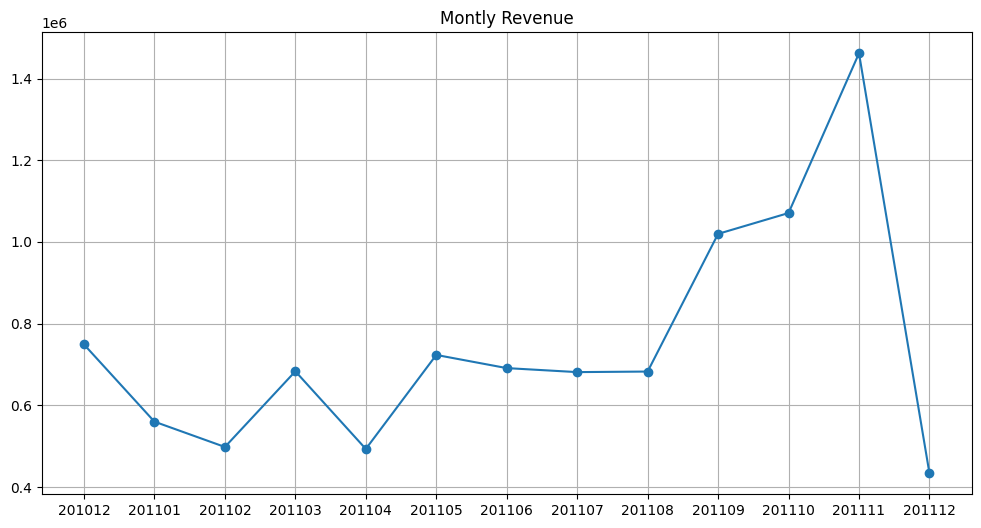

In [30]:
plt.figure(figsize=(12, 6))
plt.title('Montly Revenue')
plt.plot(tx_revenue['InvoiceYearMonth'].astype(str), tx_revenue['Revenue'], marker='o')
plt.grid()
plt.show()

This clearly shows our revenue is growing especially Aug ‘11 onwards (and our data in December is incomplete). Absolute numbers are fine, let’s figure out what is our Monthly Revenue Growth Rate:

In [31]:
tx_revenue['MonthlyGrowth'] = tx_revenue['Revenue'].pct_change()
tx_revenue

,InvoiceYearMonth,Revenue,MonthlyGrowth
0,201012,748957.020,NaN
1,201101,560000.260,-0.252293
2,201102,498062.650,-0.110603
3,201103,683267.080,0.371850
4,201104,493207.121,-0.278163
5,201105,723333.510,0.466592
6,201106,691123.120,-0.044530
7,201107,681300.111,-0.014213
8,201108,682680.510,0.002026
9,201109,1019687.622,0.493653


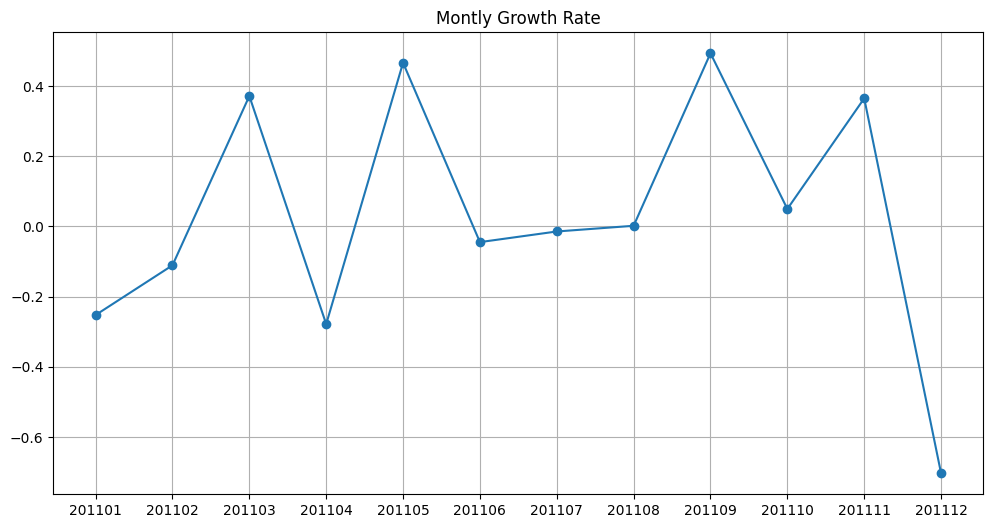

In [32]:
plt.figure(figsize=(12, 6))
plt.title('Montly Growth Rate')
plt.plot(tx_revenue['InvoiceYearMonth'].astype(str), tx_revenue['MonthlyGrowth'], marker='o')
plt.grid()
plt.show()

Everything looks good, we saw 36.5% growth previous month (December is excluded in the code since it hasn’t been completed yet). But we need to identify what exactly happened on April. Was it due to less active customers or our customers did less orders? Maybe they just started to buy cheaper products? We can’t say anything without doing a deep-dive analysis.

### Monthly Active Customers

To see the details Monthly Active Customers, we will follow the steps we exactly did for Monthly Revenue. Starting from this part, we will be focusing on UK data only (which has the most records). We can get the monthly active customers by counting unique CustomerIDs. Code snippet and the output are as follows:

In [33]:
# creating a new dataframe with UK customers only
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

# creating monthly active customers dataframe by counting unique Customer IDs
tx_monthly_active = tx_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()

# print the dataframe
tx_monthly_active

,InvoiceYearMonth,CustomerID
0,201012,871
1,201101,684
2,201102,714
3,201103,923
4,201104,817
5,201105,985
6,201106,943
7,201107,899
8,201108,867
9,201109,1177


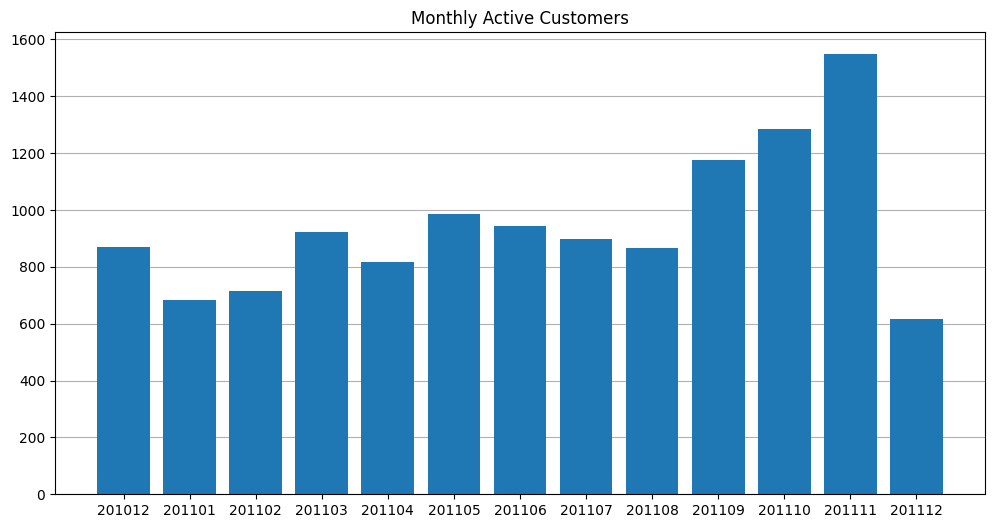

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Monthly Active Customers')
ax.bar(tx_monthly_active['InvoiceYearMonth'].astype(str), tx_monthly_active['CustomerID'])
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In April, Monthly Active Customer number dropped to 817 from 923 (-11.5%).

### Monthly Order Count
We will see the same trend for number of orders as well. We will apply the same code by using Quantity field:

In [35]:
# create a new dataframe for no. of order by using quantity field
tx_monthly_sales = tx_uk.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()

# print the dataframe
tx_monthly_sales

,InvoiceYearMonth,Quantity
0,201012,298101
1,201101,237381
2,201102,225641
3,201103,279843
4,201104,257666
5,201105,306452
6,201106,258522
7,201107,324129
8,201108,319804
9,201109,458490


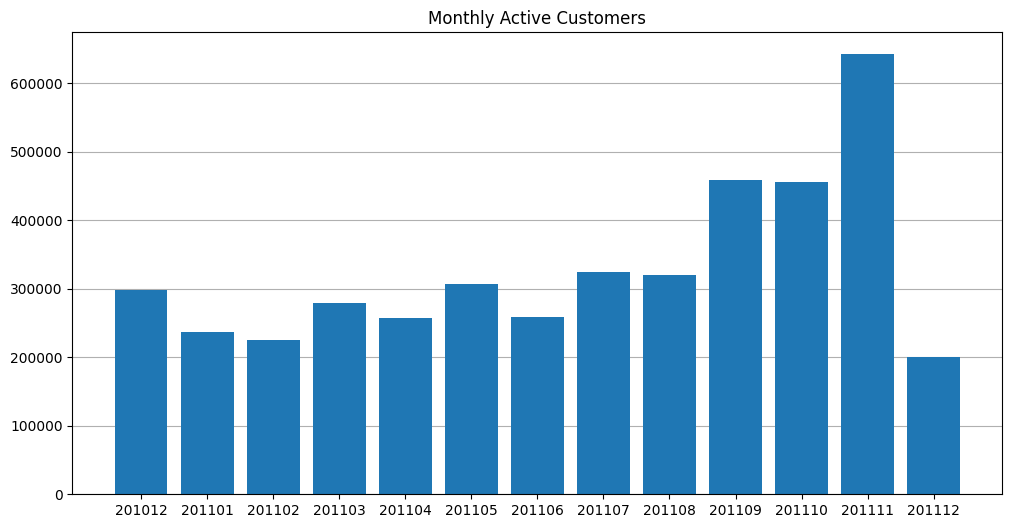

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Monthly Active Customers')
ax.bar(tx_monthly_sales['InvoiceYearMonth'].astype(str), tx_monthly_sales['Quantity'])
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

As we expected, Order Count is also declined in April (279k to 257k, -8%). We know that Active Customer Count directly affected Order Count decrease.

### Average Revenue per Order
At the end, we should definitely check our Average Revenue per Order as well. To get this data, we need to calculate the average of revenue for each month:

In [37]:
# create a new dataframe for average revenue by taking the mean of it
tx_monthly_order_avg = tx_uk.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()

# print the dataframe
tx_monthly_order_avg

,InvoiceYearMonth,Revenue
0,201012,16.865860
1,201101,13.614680
2,201102,16.093027
3,201103,16.716166
4,201104,15.773380
5,201105,17.713823
6,201106,16.714748
7,201107,15.723497
8,201108,17.315899
9,201109,18.931723


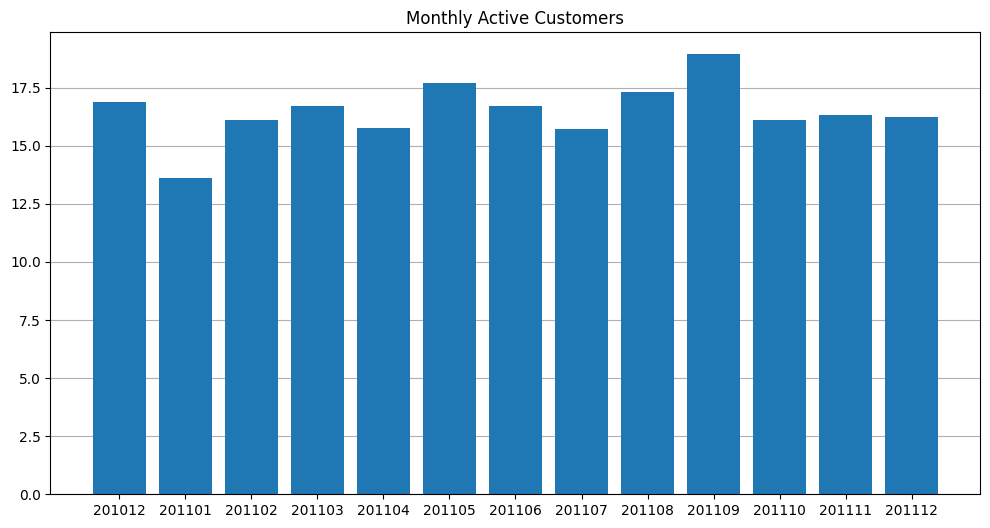

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Monthly Active Customers')
ax.bar(tx_monthly_order_avg['InvoiceYearMonth'].astype(str), tx_monthly_order_avg['Revenue'])
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

Even the monthly order average dropped for April (16.7 to 15.8). We observed slow-down in every metric affecting our North Star.

We have looked at our major metrics. Of course there are many more and it varies across industries. Let’s continue investigating some other important metrics:

New Customer Ratio: a good indicator of if we are losing our existing customers or unable to attract new ones
Retention Rate: King of the metrics. Indicates how many customers we retain over specific time window. We will be showing examples for monthly retention rate and cohort based retention rate.

### New Customer Ratio
First we should define what is a new customer. In our dataset, we can assume a new customer is whoever did his/her first purchase in the time window we defined. We will do it monthly for this example.

We will be using .min() function to find our first purchase date for each customer and define new customers based on that. The code below will apply this function and show us the revenue breakdown for each group monthly.

In [39]:
# create a dataframe contaning CustomerID and first purchase date
tx_min_purchase = tx_uk.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_min_purchase.columns = ['CustomerID', 'MinPurchaseDate']
tx_min_purchase['MinPurchaseYearMonth'] = tx_min_purchase['MinPurchaseDate'].map(
    lambda date: 100*date.year + date.month)

# merge first purchase date column to our main dataframe (tx_uk)
tx_uk = pd.merge(tx_uk, tx_min_purchase, on='CustomerID')

tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012


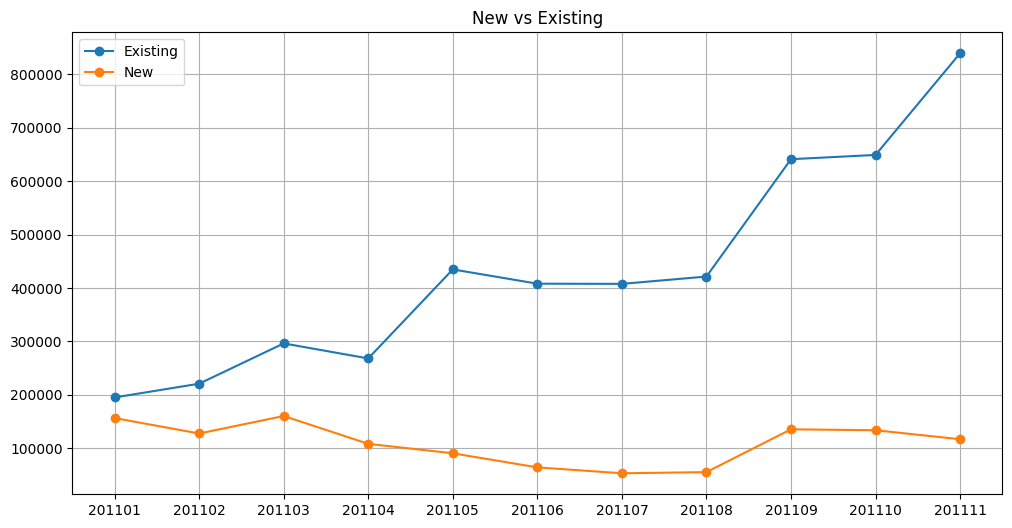

In [41]:
# create a column called User Type and assign Existing
# if User's First Purchase Year Month before the selected Invoice Year Month
tx_uk['UserType'] = 'New'
tx_uk.loc[tx_uk['InvoiceYearMonth'] >
          tx_uk['MinPurchaseYearMonth'], 'UserType'] = 'Existing'

# calculate the Revenue per month for each user type
tx_user_type_revenue = tx_uk.groupby(['InvoiceYearMonth', 'UserType'])[
    'Revenue'].sum().reset_index()

# filtering the dates and plot the result
tx_user_type_revenue = tx_user_type_revenue.query(
    "InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112")

plt.figure(figsize=(12, 6))
plt.plot(tx_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'].to_numpy(dtype=str),
         tx_user_type_revenue.query("UserType == 'Existing'")['Revenue'].to_numpy(), marker='o')

plt.plot(tx_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'].to_numpy(dtype=str),
         tx_user_type_revenue.query("UserType == 'New'")['Revenue'].to_numpy(), marker='o')

plt.title('New vs Existing')
plt.legend(['Existing', 'New'])
plt.grid()
plt.show()

Existing customers are showing a positive trend and tell us that our customer base is growing but new customers have a slight negative trend.

Let’s have a better view by looking at the New Customer Ratio:

In [42]:
# create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
tx_user_ratio = tx_uk.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() / tx_uk.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique()
tx_user_ratio = tx_user_ratio.reset_index()
tx_user_ratio = tx_user_ratio.dropna()

# print the dafaframe
tx_user_ratio

,InvoiceYearMonth,CustomerID
1,201101,1.124224
2,201102,0.904000
3,201103,0.792233
4,201104,0.510166
5,201105,0.343793
6,201106,0.281250
7,201107,0.236589
8,201108,0.192572
9,201109,0.304878
10,201110,0.328852


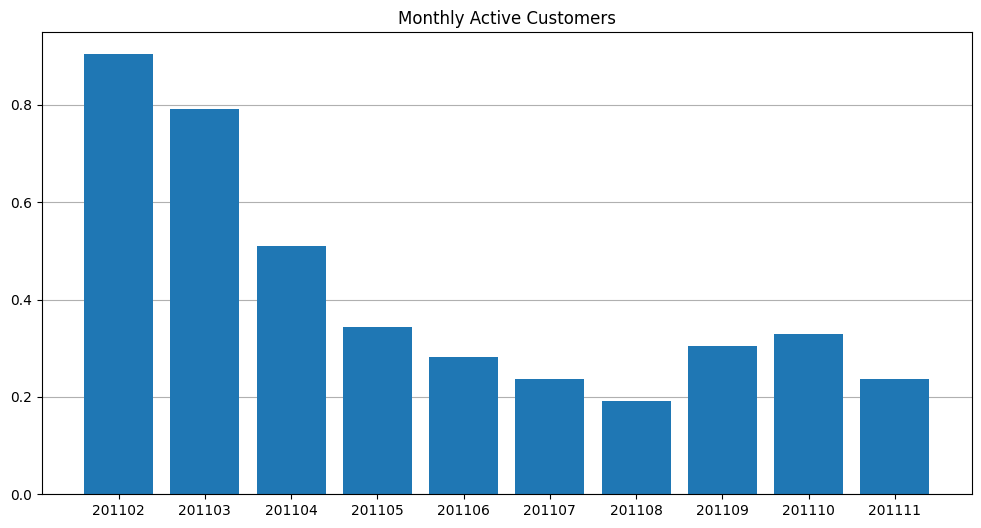

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Monthly Active Customers')
ax.bar(tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['InvoiceYearMonth'].astype(str), 
       tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['CustomerID'])
ax.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

New Customer Ratio has declined as expected (we assumed on Feb, all customers were New) and running around 20%.

### Monthly Retention Rate
Retention rate should be monitored very closely because it indicates how sticky is your service and how well your product fits the market. For making Monthly Retention Rate visualized, we need to calculate how many customers retained from previous month.

`Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total`

We will be using crosstab() function of pandas which makes calculating Retention Rate super easy.

First, we create a dataframe that shows total monthly revenue for each customer:

In [45]:
# identify which users are active by looking at their revenue per month
tx_user_purchase = tx_uk.groupby(['CustomerID', 'InvoiceYearMonth'])['Revenue'].sum().reset_index()
tx_user_purchase

,CustomerID,InvoiceYearMonth,Revenue
0,12346.0,201101,0.00
1,12747.0,201012,706.27
2,12747.0,201101,303.04
3,12747.0,201103,310.78
4,12747.0,201105,771.31
...,...,...,...
12325,18283.0,201110,114.65
12326,18283.0,201111,651.56
12327,18283.0,201112,208.00
12328,18287.0,201105,765.28


crosstab() function converts it to retention table:

In [46]:
# create retention matrix with crosstab
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceYearMonth']).reset_index()
tx_retention

InvoiceYearMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,18280.0,0,0,0,1,0,0,0,0,0,0,0,0,0
3946,18281.0,0,0,0,0,0,0,1,0,0,0,0,0,0
3947,18282.0,0,0,0,0,0,0,0,0,1,0,0,0,1
3948,18283.0,0,1,1,0,1,1,1,1,0,1,1,1,1


Retention table shows us which customers are active on each month (1 stands for active).

With the help of a simple for loop, for each month we calculate Retained Customer Count from previous month and Total Customer Count.

In [47]:
# create an array of dictionary which keeps Retained & Total User count for each month
months = tx_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month] > 0) & (
        tx_retention[prev_month] > 0)][selected_month].sum()
    retention_array.append(retention_data)

In [50]:
# convert the array to dataframe and calculate Retention Rate
tx_retention = pd.DataFrame(retention_array)
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount'] / tx_retention['TotalUserCount']
tx_retention

,InvoiceYearMonth,TotalUserCount,RetainedUserCount,RetentionRate
0,201102,714,263,0.368347
1,201103,923,305,0.330444
2,201104,817,310,0.379437
3,201105,985,369,0.374619
4,201106,943,417,0.442206
5,201107,899,379,0.421580
6,201108,867,391,0.450980
7,201109,1177,417,0.354291
8,201110,1285,502,0.390661
9,201111,1548,616,0.397933


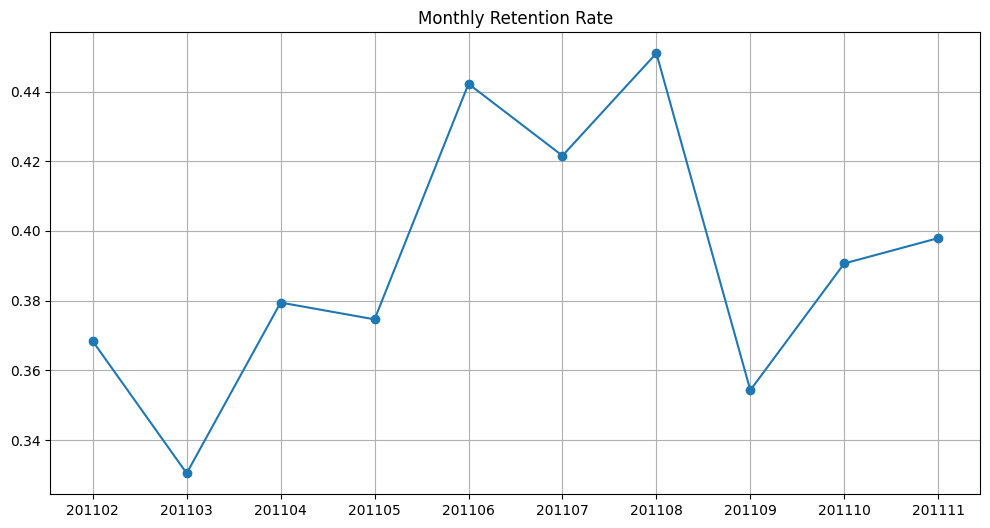

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(tx_retention.query("InvoiceYearMonth < 201112")['InvoiceYearMonth'].astype(str),
         tx_retention.query("InvoiceYearMonth < 201112")['RetentionRate'], marker='o')
plt.title('Monthly Retention Rate')
plt.grid()
plt.show()

Monthly Retention Rate significantly jumped from June to August and went back to previous levels afterwards.

### Cohort Based Retention Rate
There is another way of measuring Retention Rate which allows you to see Retention Rate for each cohort. Cohorts are determined as first purchase year-month of the customers. We will be measuring what percentage of the customers retained after their first purchase in each month. This view will help us to see how recent and old cohorts differ regarding retention rate and if recent changes in customer experience affected new customer’s retention or not.

This will be a bit more complicated than others in terms of coding.

In [53]:
# create our retention table again with crosstab() and add firs purchase year month view
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceYearMonth']).reset_index()
tx_retention = pd.merge(tx_retention,tx_min_purchase[['CustomerID','MinPurchaseYearMonth']],on='CustomerID')
new_column_names = [ 'm_' + str(column) for column in tx_retention.columns[:-1]]
new_column_names.append('MinPurchaseYearMonth')
tx_retention.columns = new_column_names

# create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count = tx_retention[tx_retention.MinPurchaseYearMonth == selected_month].MinPurchaseYearMonth.count()
    retention_data['TotalUserCount'] = total_user_count
    retention_data[selected_month] = 1 
    
    query = "MinPurchaseYearMonth == {}".format(selected_month)

    for next_month in next_months:
        new_query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(tx_retention.query(new_query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
tx_retention = pd.DataFrame(retention_array)
tx_retention.index = months

# showing new cohort based retention table
tx_retention

,TotalUserCount,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
InvoiceYearMonth,,,,,,,,,,,,,
201101,362,1.0,0.23,0.28,0.25,0.34,0.29,0.26,0.26,0.31,0.35,0.36,0.15
201102,339,NaN,1.00,0.25,0.19,0.28,0.28,0.25,0.26,0.28,0.28,0.31,0.10
201103,408,NaN,NaN,1.00,0.19,0.26,0.22,0.23,0.17,0.26,0.24,0.29,0.09
201104,276,NaN,NaN,NaN,1.00,0.22,0.22,0.22,0.21,0.23,0.23,0.26,0.08
201105,252,NaN,NaN,NaN,NaN,1.00,0.23,0.17,0.17,0.21,0.24,0.27,0.10
201106,207,NaN,NaN,NaN,NaN,NaN,1.00,0.21,0.16,0.25,0.26,0.32,0.10
201107,172,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.20,0.19,0.23,0.28,0.11
201108,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.26,0.23,0.26,0.14
201109,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.29,0.33,0.12
